In [1]:
import gym
import os
import argparse
import numpy as np
from fourrooms import Fourrooms
from scipy.special import logsumexp
from scipy.special import expit
from visualize import Display
from IPython.display import clear_output
from aoaoc_tabular import *
import matplotlib.pyplot as plt

In [10]:
class ARG:
    def __init__(self):
            self.discount=0.99
            self.lr_term=0.1
            self.lr_intra=0.25
            self.lr_critic=0.5
            self.lr_critic_pseudo=0.5
            self.lr_criticA=0.5
            self.lr_criticA_pseudo=0.5
            self.lr_attend=0.02
            self.h_learn=False
            self.xi=1.
            self.n=0.5
            self.epsilon=1e-1
            self.nepisodes=4000
            self.nruns=1
            self.nsteps=2000
            self.noptions=3
            self.baseline=True
            self.temperature=1.
            self.seed=2222
            self.seed_startstate=1111
            self.dc = 0.1
            self.wo1 = 1.   #q
            self.wo2 = 2.    #cosim
            self.wo3 = 2.    #entropy
            self.wo4 = 5.    #size
            self.wo4p = 2
            self.clipthres = 0.1
            self.stretchthres = 1.
            self.stretchstep = 1.

args = ARG()

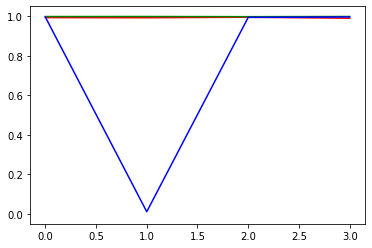

[[0.99304175 0.99230807 0.99505246 0.98997672]
 [0.99852706 0.99869389 0.99785833 0.99874725]
 [0.99637472 0.01112195 0.99420513 0.9963435 ]]
[1.98519282 1.99691339 1.72453776]
[1.38629204 1.38629427 0.9839705 ]
Run 0 episode 3999 steps 18 cumreward 11.647231830102989 avg. duration 1.9444444444444442 switches 18


In [11]:
rng = np.random.RandomState(args.seed)
env = Fourrooms(args.seed_startstate)
screen = Display()
R = 50.

# outer_dir = "AOAOC"
# if not os.path.exists(outer_dir):
#     os.makedirs(outer_dir)
# dir_name = "Rn"+str(args.nruns)+"_Ep"+str(args.nepisodes)+ "_E"+str(args.epsilon)+"_NO"+str(args.noptions)+"_LT"+ str(args.lr_term) +\
#  "_LI"+str(args.lr_intra)+"_LCA"+str(args.lr_criticA)+"_LCAP"+str(args.lr_criticA_pseudo)+"_LC"+str(args.lr_critic)+"_LCP"+str(args.lr_critic_pseudo)+"_X"+str(args.xi)+"_N"+str(args.n)+\
#  "_tm"+str(args.temperature)+"_sd"+str(args.seed)

# dir_name = os.path.join(outer_dir, dir_name)
# if not os.path.exists(dir_name):
#     os.makedirs(dir_name)

possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

num_states = env.observation_space.n
num_actions = env.action_space.n

history = np.zeros((args.nruns, args.nepisodes, 3), dtype=np.float32)

state_frequency_history = np.zeros((args.nruns, args.nepisodes, env.observation_space.n, args.noptions),dtype=np.int32)


for run in range(args.nruns):
    features = Tabular(env.observation_space.n)
    nfeatures, nactions = len(features), env.action_space.n

    policy_over_options = POO(rng, nfeatures, args, R)
    
    CoSimObj.reset()
    options = [Option(rng, nfeatures, nactions, args, R, policy_over_options, i) for i in range(args.noptions)]


    for episode in range(args.nepisodes):
        return_per_episode = 0.0
        observation = env.reset()

        phi = features(observation)
        
        screen.reset(phi)
        
        option = policy_over_options.sample(phi)

        action = options[option].sample(phi)

        traject = [[phi,option],[phi,option],action]

        cumreward = 0.
        duration = 1
        option_switches = 0
        avgduration = 0.


        for step in range(args.nsteps):
            observation, reward, done, _ = env.step(action)
            phi = features(observation)
            return_per_episode += pow(args.discount,step)*reward
            
            #render
            if (episode % 100 == 99):
                screen.render(phi, option)
                clear_output(wait=True)
                plt.figure(figsize=(5,5))
                plt.subplot(111)
                plt.imshow(screen.screen, vmax=255, vmin=0)
                plt.show()

            state_frequency_history[run, episode, observation, option] +=1

            last_option = option

            termination = options[option].terminate(phi, value=True)

            if options[option].terminate(phi):
                option = policy_over_options.sample(phi)
                option_switches += 1
                avgduration += (1./option_switches)*(duration - avgduration)
                duration = 1

            traject[0] = traject[1]
            traject[1] = [phi, option]
            traject[2] = action

#             print(options[option].policy.attention.weights)
            
            action = options[option].sample(phi)

            options[last_option].update(traject, reward, done, phi, last_option, termination)

            policy_over_options.update(traject, reward, options[last_option].distract(reward,traject[2]), done, termination)

            cumreward += options[last_option].distract(reward, traject[2])
            duration += 1
            if done:
                break

        history[run, episode, 0] = step
        history[run, episode, 1] = return_per_episode
        history[run, episode, 2] = avgduration
        
        x = np.array([0,1,2,3])
        clear_output(wait=True)
#         plt.plot( x, np.array([0,0,1,1]),'w',x,options[0].policy.attention.pmf(),'r', x,options[1].policy.attention.pmf(),'g', x,options[2].policy.attention.pmf(),'b', x,options[3].policy.attention.pmf(),'k')
        plt.plot( x, np.array([0,0,1,1]),'w',x,options[0].policy.attention.pmf(),'r', x,options[1].policy.attention.pmf(),'g',x,options[2].policy.attention.pmf(),'b')
        plt.show()
        print(np.array([options[i].policy.attention.pmf() for i in range(args.noptions)]))
        print(np.array([np.linalg.norm(options[i].policy.attention.pmf()) for i in range(args.noptions)]))
#         print(np.linalg.norm(options[0].policy.attention.pmf()))
        print(np.array([options[i].o3.loss() for i in range(args.noptions)]))

#         clear_output(wait=True)
#         occupancy = env.occupancy.astype('float64')
#         optPref = np.zeros((13,13,3), dtype="int")
#         for i in range(13):
#             for j in range(13):
#                 if occupancy[i,j] == 0:
#                     opt = np.argmax(policy_over_options.weightsP[env.tostate[(i,j)],:])
#                     if opt == 0:
#                         optPref[i,j] = np.array([255,0,0])
#                     if opt == 1:
#                         optPref[i,j] = np.array([0,255,0])
#                     if opt == 2:
#                         optPref[i,j] = np.array([0,0,255])
#                     if opt == 3:
#                         optPref[i,j] = np.array([0,0,0])
#                 else:
#                     optPref[i,j] = np.array([255,255,255])

#         plt.figure(figsize=(5,5))
#         plt.subplot(111)
#         plt.imshow(optPref, vmax=255, vmin=0)
#         plt.show()



        print('Run {} episode {} steps {} cumreward {} avg. duration {} switches {}'.format(run, episode, step, cumreward, avgduration, option_switches))

red -   1,0,0,1   up,right
green - 0,1,0,1   right,down
blue -  0,1,1,0   down,left
black - 1,0,1,0   left,up

up,down,left,right

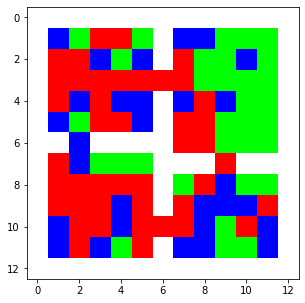

In [8]:
occupancy = env.occupancy.astype('float64')
optPref = np.zeros((13,13,3), dtype="int")
for i in range(13):
    for j in range(13):
        if occupancy[i,j] == 0:
            opt = np.argmax(policy_over_options.weightsP[env.tostate[(i,j)],:])
            if opt == 0:
                optPref[i,j] = np.array([255,0,0])
            if opt == 1:
                optPref[i,j] = np.array([0,255,0])
            if opt == 2:
                optPref[i,j] = np.array([0,0,255])
            if opt == 3:
                optPref[i,j] = np.array([0,0,0])
        else:
            optPref[i,j] = np.array([255,255,255])
            
plt.figure(figsize=(5,5))
plt.subplot(111)
plt.imshow(optPref, vmax=255, vmin=0)
plt.show()

red -   up
green - down
blue -  left
black - right

up,down,left,right

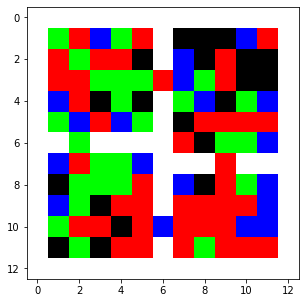

In [16]:
opt = 1
actPref = np.zeros((13,13,3), dtype="int")
occupancy = env.occupancy.astype('float64')
for i in range(13):
    for j in range(13):
        if occupancy[i,j] == 0:
            act = np.argmax(options[opt].weightsP[env.tostate[(i,j)],:])
            if act == 0:
                actPref[i,j] = np.array([255,0,0])
            if act == 1:
                actPref[i,j] = np.array([0,255,0])
            if act == 2:
                actPref[i,j] = np.array([0,0,255])
            if act == 3:
                actPref[i,j] = np.array([0,0,0])
        else:
            actPref[i,j] = np.array([255,255,255])

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.imshow(actPref, vmax=255, vmin=0)
plt.show()

In [34]:
opt = 2
st = 54

In [35]:
print(options[opt].weightsP[st])
# print(options[opt].weights)

[ 0.         49.76918749 20.43031176  0.        ]


In [36]:
print(policy_over_options.weightsP[st])
# print(options[opt].weights)

[41.89855122 41.71901708 49.76918749]


In [29]:
print(options[opt].terminate([st],True))

0.012466029178268754


In [28]:
states = np.zeros((13,13), dtype="int")
occupancy = env.occupancy.astype('float64')
s=0
for i in range(13):
    for j in range(13):
        if occupancy[i,j] == 0:
            states[i,j] = s
            s+=1
print(states)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2   3   4   0   5   6   7   8   9   0]
 [  0  10  11  12  13  14   0  15  16  17  18  19   0]
 [  0  20  21  22  23  24  25  26  27  28  29  30   0]
 [  0  31  32  33  34  35   0  36  37  38  39  40   0]
 [  0  41  42  43  44  45   0  46  47  48  49  50   0]
 [  0   0  51   0   0   0   0  52  53  54  55  56   0]
 [  0  57  58  59  60  61   0   0   0  62   0   0   0]
 [  0  63  64  65  66  67   0  68  69  70  71  72   0]
 [  0  73  74  75  76  77   0  78  79  80  81  82   0]
 [  0  83  84  85  86  87  88  89  90  91  92  93   0]
 [  0  94  95  96  97  98   0  99 100 101 102 103   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [12]:
observation = env.reset(57)
screen.reset(phi)

option = policy_over_options.sample(phi)
option = 2
# print(option)
action = options[option].sample(phi)

for step in range(args.nsteps):
    observation, reward, done, _ = env.step(action)
    phi = features(observation)

    #render

    screen.render(phi, option)
    clear_output(wait=True)
    plt.figure(figsize=(5,5))
    plt.subplot(111)
    plt.imshow(screen.screen, vmax=255, vmin=0)
    plt.show()

#     if options[option].terminate(phi):
#         option = policy_over_options.sample(phi)

    action = options[option].sample(phi)

    if done:
        break


KeyboardInterrupt: 

In [6]:
for m in range(args.noptions):
    print(options[m].policy.attention.pmf())

[0.01287851 0.01287851 0.01287851 0.30105645]
[0.42543244 0.01295603 0.01295603 0.01186467]
[0.01206231 0.01865672 0.52709504 0.01206886]


In [29]:
print(options[2].policy.internalPI.pmf([54]))

[2.13176204e-06 9.99995734e-01 2.35683896e-09 2.13176204e-06]


In [11]:
normalizer = np.linalg.norm(options[2].policy.attention.pmf())
normh = options[2].policy.attention.pmf()/normalizer
print(normh)
print(normh * np.log(normh))


[0.02285823 0.03535472 0.99885158 0.02287064]
[-0.08636855 -0.1181669  -0.00114776 -0.08640301]
